In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage import color, exposure, filters, io, morphology, util
from math import sqrt
from numpy import loadtxt
from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Reshape
from keras.optimizers import SGD

### TRANSFER LEARNING

#### 1.
Bangun sebuah model $\text{Convolutional Neural Network}$ dengan arsitektur dasar sebagai berikut :
- Convolutional Layer ($25$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Convolutional Layer ($50$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Convolutional Layer ($100$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Hidden Layer ($100$ neuron)
- Activation Function ($\text{ReLU function}$)
- Output Layer ($10$ kelas)
- Activation Function ($\text{Softmax function}$)
- Classification Result

Dengan tambahan beberapa seperti:
- Adam optimization
- Early Stop

##### Mendefinisikan Fungsi Bantuan
Untuk memudahkan implementasi, berikut beberapa fungsi bantuan yang akan dipakai

###### Menghitung $\text{recall}$ atau $\text{sensitivity}$
$$\text{recall} = \frac{t_p}{t_p+t_n}$$

In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

###### Menghitung $\text{precision}$
$$\text{precision} = \frac{t_p}{t_p + f_p}$$

In [3]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

###### Menghitung $\text{specificity}$
$$\text{specificity} = \frac{t_n}{t_n + f_p}$$

In [4]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

###### Menghitung $f_{1}\text{ Score}$
Kita tau bahwa
$$f_{\beta} = (1 + \beta^{2}) \cdot \frac{\text{precision} \cdot \text{recall}}{(\beta^{2} \cdot \text{precision}) + \text{recall}}$$
Sehingga 
$$f_{1} = (1 + 1^{2}) \cdot \frac{\text{precision} \cdot \text{recall}}{(1^{2} \cdot \text{precision}) + \text{recall}}$$
$$f_{1} = (2) \cdot \frac{\text{precision} \cdot \text{recall}}{(\text{precision}) + \text{recall}}$$



In [5]:
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val * recall_val)/(precision_val + recall_val + K.epsilon()))

**n.b.: Semua fungsi pada bagian penyebut ditambah epsilon untuk menghindari dibagi $0$ dikarenakan memasukkan input sebanyak $0$**

###### Fungsi Bantuan untuk Melakukan Prediksi dan Menampilkan Metric

In [6]:
def predict_and_get_metrics(model, x_test, y_test, label):
    _, accuracy, sensitivity, specificity, score_f1 = model.evaluate(x_test, y_test, verbose=0)
    return pd.DataFrame([[accuracy, sensitivity, specificity, score_f1]], columns=['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score'], index=[label])

def compare_train_and_test(model, x_train, y_train, x_test, y_test, extra_label=''):
    metric_train = predict_and_get_metrics(model, x_train, y_train, 'Data Train %s' % (extra_label))
    metric_test = predict_and_get_metrics(model, x_test, y_test, 'Data Test %s' % (extra_label))
    return pd.concat([metric_train, metric_test])

###### Fungsi Bantuan untuk _Load Dataset_

In [7]:
def load_dataset_cifar10():
	(trainX, trainY), (testX, testY) = keras.datasets.cifar10.load_data()
	return np.concatenate((trainX, testX), axis=0), np.concatenate((trainY, testY), axis=0)
 
def load_dataset_cifar100():
	(trainX, trainY), (testX, testY) = keras.datasets.cifar100.load_data()
	return np.concatenate((trainX, testX), axis=0), np.concatenate((trainY, testY), axis=0)

##### Load Dataset

In [8]:
x, y = load_dataset_cifar10()
x.shape

170500096/170498071 [==============================] - 2s 0us/step


(60000, 32, 32, 3)

##### Mengambil Dataset Sebanyak 1000 Per Kelasnya

In [9]:
idx_sample = np.array([],dtype=int)

for i in range(10):
    idx = (y == i).reshape(x.shape[0])
    idx_data = np.where(idx == True)
    sampled_list = np.random.choice(idx_data[0], size=1000, replace=False)
    idx_sample = np.concatenate((idx_sample, sampled_list), axis=0)

##### Melakukan Validasi Apakah Shape-nya Sudah Valid atau Belum

In [10]:
x_sample = x[idx_sample]
y_sample = y[idx_sample]
x_sample.shape, y_sample.shape

((10000, 32, 32, 3), (10000, 1))

##### Melakukan Normalisasi untuk $x$

In [11]:
def normalize(x):
    return x / 255.0

x_sample = normalize(x_sample)

##### Merubah Menjadi Matrix Binary untuk $y$

In [12]:
y_sample = tf.keras.utils.to_categorical(y_sample)

##### Memecah Menjadi 60 : 40 ~ Train : Test

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.4)

##### Membangun Model Convolutional Neural Network

In [14]:
def create_model(learning_rate, pre_defined_layers=[]):
    convolutional_layers = []
    if len(pre_defined_layers) == 0:
        ## Convolutional Layers 25 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(25, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        ## Convolutional Layers 50 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(50, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        ## Convolutional Layers 100 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(100, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        convolutional_layers.append(Flatten())

        ## Hidden Layer 100 node
        convolutional_layers.append(Dense(100, activation=tf.nn.relu))

        ## Output 10 class
        convolutional_layers.append(Dense(10, activation=tf.nn.softmax))
    else:
        convolutional_layers = pre_defined_layers

    ## Menginisialisasi instance model
    convolutional_model = Sequential(convolutional_layers)

    ## Membangun model
    convolutional_model.build(input_shape=x_train.shape)

    ## Melakukan Kompilasi ke dalam Model
    convolutional_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
      'accuracy',
      recall,
      specificity,
      f1_score
    ])

    return convolutional_model

##### Melakukan _fitting_ dengan $\text{epochs} = 100$, $\text{batch_size} = 10$, dan $\text{learning_rate} = 0.1$, dan $\text{Early Stopping}$

In [89]:
## Mendefinisikan Early Stopping untuk Semua Model CNN Awal
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [18]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 17s 28ms/step - loss: 33.3669 - accuracy: 0.1025 - recall: 0.0017 - specificity: 0.9992 - f1_score: 0.0017 - val_loss: 2.3419 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 17s 28ms/step - loss: 2.3280 - accuracy: 0.0980 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3178 - val_accuracy: 0.0967 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
600/600 [==============================] - 17s 28ms/step - loss: 2.3239 - accuracy: 0.0963 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3316 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


#### 3.
Lakukan skenario eksperimen untuk mendapatkan metrik evaluasi optimal ($\text{akurasi}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1} \text{ score}$) dengan mengubah parameter yaitu:
1. Mengubah epoch, dengan $\text{learning_rate} = 0.1$ dan $\text
{batch_number} = 10$.
2. Mengubah jumlah $\text{batch number}$ dengan $\text{epoch}$ optimal dari skenario (1) dan $\text{learning_rate} = 0.1$.
3. Mengubah $\text{learning_rate}$ dengan $\text{epoch}$ optimal dari skenario (1) dan jumlah $\text{batch_number}$ optimal dari skenario (2).

##### Melakukan Skenario 3.1. (Mengubah $\text{epoch}$)

###### Skenario 3.1.1. ($\text{epoch} = 100$)

In [19]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 17s 28ms/step - loss: 10.1143 - accuracy: 0.0957 - recall: 8.3333e-04 - specificity: 0.9993 - f1_score: 9.6970e-04 - val_loss: 2.3212 - val_accuracy: 0.1032 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 17s 28ms/step - loss: 2.3274 - accuracy: 0.0962 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3301 - val_accuracy: 0.0975 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario 3.1.2. ($\text{epoch} = 50$)

In [20]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=50, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/50
600/600 [==============================] - 19s 31ms/step - loss: 17.3637 - accuracy: 0.1090 - recall: 5.0000e-04 - specificity: 0.9995 - f1_score: 5.0877e-04 - val_loss: 2.3244 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/50
600/600 [==============================] - 17s 28ms/step - loss: 2.3240 - accuracy: 0.0985 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3366 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario 3.1.3. ($\text{epoch}$ = 25)

In [21]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=25, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/25
600/600 [==============================] - 17s 29ms/step - loss: 26.3350 - accuracy: 0.0990 - recall: 0.0015 - specificity: 0.9989 - f1_score: 0.0015 - val_loss: 2.3229 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/25
600/600 [==============================] - 16s 27ms/step - loss: 2.3241 - accuracy: 0.1000 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3191 - val_accuracy: 0.1070 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/25
600/600 [==============================] - 17s 28ms/step - loss: 2.3237 - accuracy: 0.1003 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3297 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario 3.1.4. ($\text{epoch}$ = 10)

In [22]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
600/600 [==============================] - 17s 28ms/step - loss: 12.4968 - accuracy: 0.0990 - recall: 0.0033 - specificity: 0.9987 - f1_score: 0.0033 - val_loss: 2.3266 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
600/600 [==============================] - 16s 27ms/step - loss: 2.3284 - accuracy: 0.0967 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3272 - val_accuracy: 0.0960 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario 3.1.5. ($\text{epoch} = 5$)



In [23]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=5, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/5
600/600 [==============================] - 17s 28ms/step - loss: 11.8267 - accuracy: 0.0932 - recall: 3.3333e-04 - specificity: 0.9997 - f1_score: 3.3333e-04 - val_loss: 2.3229 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/5
600/600 [==============================] - 17s 28ms/step - loss: 2.3261 - accuracy: 0.1010 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3293 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Kesimpulan Skenario $3.1.$

Berdasarkan hasil dari skenario $3.1.1.$, $3.1.2.$, $3.1.3.$, $3.1.4.$, dan $3.1.5.$, kelima skenario mengalami _early stop_ pada $\text{epoch} \leq 5$. Kelima skenario menghasilkan akurasi yang rendah pula, dengan demikian, digunakan $\text{epoch}$ terbesar ($\text{epoch} = 100$) dikarenakan sudah ada penjaga _early stop_ untuk mengecek ke _convergen_-an.

##### Melakukan Skenario $3.2.$ (Mengubah $\text{batch_number}$)

###### Skenario $3.2.1.$ ($\text{batch_number} = 10$)

In [24]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 17s 28ms/step - loss: 15.2138 - accuracy: 0.0990 - recall: 0.0010 - specificity: 0.9992 - f1_score: 0.0011 - val_loss: 2.3456 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 22s 37ms/step - loss: 2.3246 - accuracy: 0.0982 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3227 - val_accuracy: 0.1032 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
600/600 [==============================] - 17s 29ms/step - loss: 2.3252 - accuracy: 0.1032 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3302 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.2.$ ($\text{batch_number} = 25$)

In [25]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
240/240 [==============================] - 14s 58ms/step - loss: 35.0576 - accuracy: 0.0983 - recall: 8.3333e-04 - specificity: 0.9983 - f1_score: 8.4397e-04 - val_loss: 2.3213 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
240/240 [==============================] - 14s 59ms/step - loss: 2.3165 - accuracy: 0.0903 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3197 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
240/240 [==============================] - 14s 58ms/step - loss: 2.3156 - accuracy: 0.0987 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3351 - val_accuracy: 0.0975 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.3.$ ($\text{batch_number} = 50$)

In [26]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=50, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
120/120 [==============================] - 13s 107ms/step - loss: 156.5080 - accuracy: 0.1045 - recall: 0.0028 - specificity: 0.9966 - f1_score: 0.0028 - val_loss: 2.3135 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
120/120 [==============================] - 13s 106ms/step - loss: 2.3096 - accuracy: 0.1032 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3103 - val_accuracy: 0.0967 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
120/120 [==============================] - 13s 107ms/step - loss: 2.3117 - accuracy: 0.0957 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3068 - val_accuracy: 0.1070 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
120/120 [==============================] - 13s 106ms/step - loss: 2.3134 - accuracy: 0.0913 - recall: 0.0000e+00 - specifici

###### Skenario $3.2.4.$ ($\text{batch_number} = 75$)

In [27]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
60/60 [==============================] - 12s 203ms/step - loss: 42.1939 - accuracy: 0.0925 - recall: 0.0030 - specificity: 0.9966 - f1_score: 0.0030 - val_loss: 2.3097 - val_accuracy: 0.0975 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
60/60 [==============================] - 12s 196ms/step - loss: 2.3093 - accuracy: 0.0972 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3059 - val_accuracy: 0.0967 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
60/60 [==============================] - 12s 196ms/step - loss: 2.3070 - accuracy: 0.0965 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3065 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.5.$ ($\text{batch_number} = 100$)

In [28]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
30/30 [==============================] - 12s 386ms/step - loss: 331.9952 - accuracy: 0.1007 - recall: 0.0097 - specificity: 0.9900 - f1_score: 0.0097 - val_loss: 2.3046 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
30/30 [==============================] - 11s 369ms/step - loss: 2.3079 - accuracy: 0.0982 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3061 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.2.6.$ ($\text{batch_number} = 250$)

In [29]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=250, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
24/24 [==============================] - 11s 467ms/step - loss: 255.9295 - accuracy: 0.0972 - recall: 0.0090 - specificity: 0.9910 - f1_score: 0.0097 - val_loss: 2.3085 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 11s 455ms/step - loss: 2.3068 - accuracy: 0.0985 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3154 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.2.7.$ ($\text{batch_number} = 500$)

In [30]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=500, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
12/12 [==============================] - 11s 891ms/step - loss: 504.7993 - accuracy: 0.0958 - recall: 0.0183 - specificity: 0.9826 - f1_score: 0.0190 - val_loss: 2.3402 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 11s 877ms/step - loss: 2.3260 - accuracy: 0.0965 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3181 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
12/12 [==============================] - 10s 871ms/step - loss: 2.3099 - accuracy: 0.0987 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3072 - val_accuracy: 0.0960 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
12/12 [==============================] - 10s 873ms/step - loss: 2.3052 - accuracy: 0.0963 - recall: 0.0000e+00 - specificity: 1.00

###### Skenario $3.2.8.$ ($\text{batch_number} = 750$)

In [31]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=750, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
8/8 [==============================] - 10s 1s/step - loss: 2041.9570 - accuracy: 0.1057 - recall: 0.0495 - specificity: 0.9568 - f1_score: 0.0513 - val_loss: 2.3379 - val_accuracy: 0.0960 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 2.3183 - accuracy: 0.1030 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3174 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 2.3059 - accuracy: 0.1042 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3084 - val_accuracy: 0.0975 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 2.3065 - accuracy: 0.0970 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.00

###### Skenario $3.2.9.$ ($\text{batch_number} = 1000$)

In [32]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=1000, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
6/6 [==============================] - 10s 2s/step - loss: 2823.5669 - accuracy: 0.0930 - recall: 0.0477 - specificity: 0.9501 - f1_score: 0.0478 - val_loss: 2.4410 - val_accuracy: 0.0967 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 9s 2s/step - loss: 2.3408 - accuracy: 0.0978 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3319 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 9s 2s/step - loss: 2.3171 - accuracy: 0.1002 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3208 - val_accuracy: 0.0975 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 9s 2s/step - loss: 2.3113 - accuracy: 0.1005 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e

###### Skenario $3.2.10.$ ($\text{batch_number} = |\text{data_train}|$)

In [33]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=len(x_train), validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 2.7696 - accuracy: 0.0878 - recall: 0.0000e+00 - specificity: 0.9999 - f1_score: 0.0000e+00 - val_loss: 12120.4717 - val_accuracy: 0.1070 - val_recall: 0.1070 - val_specificity: 0.9008 - val_f1_score: 0.1070
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 12188.6133 - accuracy: 0.0953 - recall: 0.0953 - specificity: 0.8995 - f1_score: 0.0953 - val_loss: 56.3462 - val_accuracy: 0.1007 - val_recall: 0.1007 - val_specificity: 0.9001 - val_f1_score: 0.1007
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 55.1954 - accuracy: 0.0995 - recall: 0.0995 - specificity: 0.8999 - f1_score: 0.0995 - val_loss: 9.6537 - val_accuracy: 0.0978 - val_recall: 0.0885 - val_specificity: 0.9174 - val_f1_score: 0.0966
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 9.3452 - accuracy: 0.1023 - recall: 0.0897 - specificity: 0.9180 - f1_score: 0.0981 - val_loss: 2.5952 - val_accur

###### Kesimpulan Skenario $3.2.$

Berdasarkan hasil dari skenario $3.2.1.$, $3.2.2.$, $3.2.3.$, $3.2.4.$, $3.2.5.$, $3.2.6.$, $3.2.7.$, $3.2.8.$, $3.2.9.$, dan $3.2.10.$, kesepuluh skenario mengalami _early stop_ pada $\text{epoch} \leq 10$. Semua skenario memiliki nilai akurasi yang rendah (sekitar $\pm 10\%$). Sulit untuk menentukan parameter optimal dari kelima skenario dengan urutan pengambilan skenario dari $\text{batch_size}$ terlebih dahulu ketimbang $\text{learning_rate}$. Untuk keberlanjutan skenario, penentuan $\text{batch_size}$ digunakan pendekatan $\text{batch_size} \geq \sqrt{|sampel|} = \sqrt{10000 \cdot 0,6} \approx 77$. Nilai $\text{batch_size}$ yang mendekati dari skenario tersebut adalah nilai $\text{batch_size}$ pada skenario $3.2.4.$ yaitu $75$.

##### Melakukan Skenario $3.3.$ (Mengubah $\text{learning_rate}$)

###### Skenario $3.3.1.$ ($\text{learning_rate} = 0.25$)

In [34]:
convolutional_model = create_model(0.25)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 154ms/step - loss: 8134.2158 - accuracy: 0.0998 - recall: 0.0048 - specificity: 0.9932 - f1_score: 0.0048 - val_loss: 2.3071 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 150ms/step - loss: 2.3148 - accuracy: 0.0987 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3264 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.3.2.$ ($\text{learning_rate} = 0.1$)

In [90]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 13s 157ms/step - loss: 121.2754 - accuracy: 0.0972 - recall: 0.0080 - specificity: 0.9929 - f1_score: 0.0081 - val_loss: 2.3036 - val_accuracy: 0.0975 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 149ms/step - loss: 2.3094 - accuracy: 0.0963 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3044 - val_accuracy: 0.1007 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.3.3.$ ($\text{learning_rate} = 0.05$)

In [35]:
convolutional_model = create_model(0.05)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 155ms/step - loss: 5.2252 - accuracy: 0.1050 - recall: 0.0032 - specificity: 0.9975 - f1_score: 0.0034 - val_loss: 2.3100 - val_accuracy: 0.0960 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 152ms/step - loss: 2.3084 - accuracy: 0.0982 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3067 - val_accuracy: 0.0970 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 12s 152ms/step - loss: 2.3055 - accuracy: 0.0947 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3040 - val_accuracy: 0.1032 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 12s 152ms/step - loss: 2.3056 - accuracy: 0.1022 - recall: 0.0000e+00 - specificity: 1.0000

###### Skenario $3.3.4.$ ($\text{learning_rate} = 0.01$)

In [36]:
convolutional_model = create_model(0.01)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 13s 157ms/step - loss: 2.4333 - accuracy: 0.1623 - recall: 0.0033 - specificity: 0.9981 - f1_score: 0.0057 - val_loss: 2.0327 - val_accuracy: 0.2455 - val_recall: 0.0037 - val_specificity: 0.9996 - val_f1_score: 0.0073
Epoch 2/100
80/80 [==============================] - 12s 153ms/step - loss: 1.8043 - accuracy: 0.3367 - recall: 0.0647 - specificity: 0.9942 - f1_score: 0.1124 - val_loss: 1.7357 - val_accuracy: 0.3618 - val_recall: 0.1106 - val_specificity: 0.9916 - val_f1_score: 0.1849
Epoch 3/100
80/80 [==============================] - 12s 156ms/step - loss: 1.6181 - accuracy: 0.4177 - recall: 0.1475 - specificity: 0.9899 - f1_score: 0.2347 - val_loss: 1.6401 - val_accuracy: 0.4020 - val_recall: 0.1546 - val_specificity: 0.9886 - val_f1_score: 0.2444
Epoch 4/100
80/80 [==============================] - 13s 159ms/step - loss: 1.5000 - accuracy: 0.4510 - recall: 0.2218 - specificity: 0.9871 - f1_score: 0.3291 - val_loss: 1.5452 - val

###### Skenario $3.3.5.$ ($\text{learning_rate} = 0.005$)

In [37]:
convolutional_model = create_model(0.005)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 155ms/step - loss: 2.2852 - accuracy: 0.1903 - recall: 0.0080 - specificity: 0.9968 - f1_score: 0.0127 - val_loss: 1.9011 - val_accuracy: 0.2973 - val_recall: 0.0822 - val_specificity: 0.9883 - val_f1_score: 0.1370
Epoch 2/100
80/80 [==============================] - 12s 151ms/step - loss: 1.7017 - accuracy: 0.3807 - recall: 0.1055 - specificity: 0.9914 - f1_score: 0.1747 - val_loss: 1.6187 - val_accuracy: 0.4060 - val_recall: 0.1657 - val_specificity: 0.9883 - val_f1_score: 0.2586
Epoch 3/100
80/80 [==============================] - 12s 152ms/step - loss: 1.5442 - accuracy: 0.4300 - recall: 0.1982 - specificity: 0.9870 - f1_score: 0.2987 - val_loss: 1.6434 - val_accuracy: 0.4120 - val_recall: 0.1607 - val_specificity: 0.9891 - val_f1_score: 0.2539
Epoch 00003: early stopping


###### Skenario $3.3.6.$ ($\text{learning_rate} = 0.001$)

In [38]:
convolutional_model = create_model(0.001)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 14s 176ms/step - loss: 2.0701 - accuracy: 0.2437 - recall: 0.0125 - specificity: 0.9985 - f1_score: 0.0230 - val_loss: 1.7434 - val_accuracy: 0.3722 - val_recall: 0.0472 - val_specificity: 0.9966 - val_f1_score: 0.0866
Epoch 2/100
80/80 [==============================] - 18s 226ms/step - loss: 1.6177 - accuracy: 0.4168 - recall: 0.1270 - specificity: 0.9918 - f1_score: 0.2082 - val_loss: 1.6134 - val_accuracy: 0.4223 - val_recall: 0.1519 - val_specificity: 0.9904 - val_f1_score: 0.2432
Epoch 3/100
80/80 [==============================] - 18s 220ms/step - loss: 1.4259 - accuracy: 0.4857 - recall: 0.2288 - specificity: 0.9887 - f1_score: 0.3400 - val_loss: 1.4329 - val_accuracy: 0.4820 - val_recall: 0.2585 - val_specificity: 0.9862 - val_f1_score: 0.3719
Epoch 4/100
80/80 [==============================] - 18s 223ms/step - loss: 1.2938 - accuracy: 0.5362 - recall: 0.3118 - specificity: 0.9866 - f1_score: 0.4336 - val_loss: 1.4453 - val

###### Kesimpulan Skenario $3.3.$

Berdasarkan hasil dari skenario $3.3.1.$, $3.3.2.$, $3.3.3.$, $3.3.4.$, $3.3.5.$ dan $3.3.6.$, skenario $3.3.4.$ menghasilkan akurasi yang paling baik. Dengan demikian $\text{learning_rate}$ optimal dari skenario-skenario tersebut adalah $\text{learning_rate}$ dari skenario $3.3.4.$, yaitu $0.001$.

#### 4.
Simpan _checkpoint_ dari tiap _interval_ $\text{epoch}$ dan model final dari proses training dari model $\text{Convolutional Neural Network}$ dengan parameter optimal yang diperoleh dari skenario agar bisa digunakan kembali untuk proses training selanjutnya.

In [39]:
checkpoint = ModelCheckpoint("checkpoint_model.h5", monitor='loss', verbose=1, mode='auto', save_freq=1)
final_convolutional_model = create_model(0.001)
history = final_convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es, checkpoint])

Epoch 1/100

Epoch 00001: saving model to checkpoint_model.h5
 1/80 [..............................] - ETA: 0s - loss: 2.4733 - accuracy: 0.0800 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00
Epoch 00001: saving model to checkpoint_model.h5
 2/80 [..............................] - ETA: 6s - loss: 2.4923 - accuracy: 0.0933 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00
Epoch 00001: saving model to checkpoint_model.h5
 3/80 [>.............................] - ETA: 8s - loss: 2.4144 - accuracy: 0.1244 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00
Epoch 00001: saving model to checkpoint_model.h5
 4/80 [>.............................] - ETA: 9s - loss: 2.4036 - accuracy: 0.1167 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00
Epoch 00001: saving model to checkpoint_model.h5
 5/80 [>.............................] - ETA: 10s - loss: 2.3793 - accuracy: 0.1253 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e

#### 5.
Visualisasikan _error_ dari proses training yang diperoleh dari tiap $\text{epoch}$ dan tampilkan matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1} \text{ score}$) dari data test.

In [40]:
predict_and_get_metrics(final_convolutional_model, x_test, y_test, label='Data Test')

,Accuracy,Sensitivity,Specificity,F1 Score
Data Test,0.59025,0.49525,0.974666,0.57313


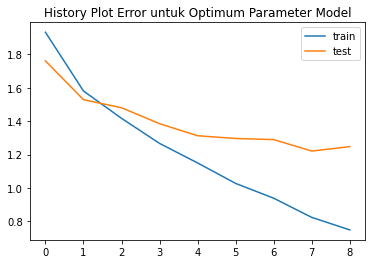

In [42]:
## Plot Training History
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model')
plt.legend()
plt.show()

#### 6.
Gunakan _pre-trained_ model yg telah dibuat tersebut untuk diimplementasikan pada dataset $\text{CIFAR 100}$ untuk kelas $1$ hingga kelas $10$ (masing-masing kelas terdiri dari
$100$ citra) dengan rasio _data train_ dan _data test_ sebanyak $60\% : 40\%$. Kemudian hitung matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1}\text{ score}$) dari _data train_ dan _data test_.

##### Load Data CIFAR 100

In [43]:
x_100, y_100 = load_dataset_cifar100()
x_100.shape

169009152/169001437 [==============================] - 3s 0us/step


(60000, 32, 32, 3)

##### Mengambil Dataset Sebanyak 100 Per Kelasnya

In [44]:
idx_sample_100 = np.array([],dtype=int)

for i in range(10):
    idx = (y == i).reshape(x.shape[0])
    idx_data = np.where(idx == True)
    sampled_list = np.random.choice(idx_data[0], size=100, replace=False)
    idx_sample_100 = np.concatenate((idx_sample_100, sampled_list), axis=0)

##### Melakukan Validasi Apakah Shape-nya Sudah Valid atau Belum

In [45]:
x_sample_100 = x[idx_sample_100]
y_sample_100 = y[idx_sample_100]
x_sample_100.shape, y_sample_100.shape

((1000, 32, 32, 3), (1000, 1))

##### Melakukan Normalisasi untuk $x$

In [46]:
x_sample_100 = normalize(x_sample_100)

##### Merubah Menjadi Matrix Binary untuk $y$

In [47]:
y_sample_100 = tf.keras.utils.to_categorical(y_sample_100)

##### Memecah Menjadi 60 : 40 ~ Train : Test

In [48]:
x_train_100, x_test_100, y_train_100, y_test_100 = train_test_split(x_sample_100, y_sample_100, test_size=0.4)

##### Melakukan Evaluasi Pre-Trained Model dari Train Sebelumnya

In [78]:
pre_trained_model = load_model('checkpoint_model.h5', compile=True, custom_objects={
    "recall": recall,
    "specificity": specificity,
    "f1_score": f1_score
})
compare_train_and_test(pre_trained_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.615,0.511513,0.978984,0.600037
Data Test,0.585,0.495192,0.978098,0.584703


#### 7.
Buat arsitektur $\text{Convolutional Neural Network}$ yang baru dengan menggunakan semua _hidden layer pre-trained_ dari model sebelumnya, lakukan _freezing_ pada semua _hidden layer_ tersebut, lalu ganti _layer output_ $\text{softmax}$ dengan layer baru.

In [79]:
## Fungsi untuk melakukan freeze pada layer
def make_freeze(layer):
    layer.trainable = False
    return layer

## Melakukan copy untuk semua layer
copy_layers = [make_freeze(layer) for layer in pre_trained_model.layers]

## Me-replace ouput layer dengan layer baru yang trainable
copy_layers[-1] = Dense(10, activation=tf.nn.softmax)

## Membangun Model
new_cnn_model = create_model(0.001, copy_layers)

#### 8.
Implementasikan model poin $(7)$ pada dataset $\text{CIFAR 100}$ untuk kelas $1$ hingga kelas $10$ dengan rasio _data train_ dan _data test_ sebanyak $60\% : 40\%$. Kemudian hitung matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specificity}$, dan $f_{1}\text{ score}$) dari _data train_ dan _data test_.

##### Melakukan Train pada Model CNN Baru

In [80]:
## Mendefinisikan Early Stopping untuk Semua Model CNN Checkpoint dan Seterusnya
## Menambah Parameter Patience karena Data Training Lebih Sedikit Sehingga Tidak Terlalu Masalah untuk Melakukan Iterasi Epoch Lebih Banyak Karena Proses Train Akan 100 kali Lebih Cepat dibandingkan Sebelumnya 
new_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [81]:
checkpoint = ModelCheckpoint("checkpoint_new_cnn_model.h5", monitor='loss', verbose=0, mode='auto', save_freq=1)

## Menurunkan jumlah batch seiring dengan berkurangnya jumlah data train
new_cnn_model_history = new_cnn_model.fit(x_train_100, y_train_100, epochs=100, batch_size=10, validation_data=(x_test_100, y_test_100), use_multiprocessing=True, callbacks=[new_es, checkpoint])

Epoch 1/100
60/60 [==============================] - 2s 38ms/step - loss: 3.0900 - accuracy: 0.1650 - recall: 0.0633 - specificity: 0.9739 - f1_score: 0.0941 - val_loss: 2.5822 - val_accuracy: 0.2050 - val_recall: 0.0425 - val_specificity: 0.9844 - val_f1_score: 0.0669
Epoch 2/100
60/60 [==============================] - 2s 36ms/step - loss: 2.1876 - accuracy: 0.2467 - recall: 0.0667 - specificity: 0.9891 - f1_score: 0.1110 - val_loss: 2.1165 - val_accuracy: 0.2600 - val_recall: 0.0625 - val_specificity: 0.9872 - val_f1_score: 0.1006
Epoch 3/100
60/60 [==============================] - 2s 37ms/step - loss: 1.8347 - accuracy: 0.3383 - recall: 0.0967 - specificity: 0.9915 - f1_score: 0.1571 - val_loss: 1.8687 - val_accuracy: 0.3275 - val_recall: 0.1125 - val_specificity: 0.9867 - val_f1_score: 0.1748
Epoch 4/100
60/60 [==============================] - 2s 33ms/step - loss: 1.6343 - accuracy: 0.3967 - recall: 0.1433 - specificity: 0.9906 - f1_score: 0.2157 - val_loss: 1.7346 - val_accurac

##### Menghitung Matrik Evaluasi Model CNN Baru

In [82]:
compare_train_and_test(new_cnn_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.701667,0.572917,0.984101,0.664181
Data Test,0.540000,0.466346,0.973291,0.546970


##### Melakukan _Plotting Error_

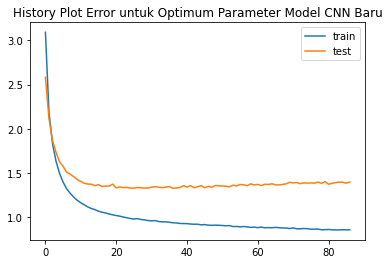

In [83]:
## Plot Training History
plt.plot(new_cnn_model_history.history['loss'], label='train')
plt.plot(new_cnn_model_history.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model CNN Baru')
plt.legend()
plt.show()

#### 9.
Lalu lakukan _unfreeze_ pada satu _hidden layer_ ($\text{conv-pool-actv}$) paling atas dan lakukan kembali proses training menggunakan deskripsi data yang sama dengan poin $(8)$. Bagaimana hasil yang diperoleh dari perubahan ini?

##### Melakukan _unfreeze_ pada satu _hidden layer_ paling atas

In [84]:
## Disclaimer: Asumsi model-nya sama dengan (8)
## Melakukan unfreeze pada hidden layer paling atas
new_cnn_model.layers[0].trainable = True

##### Melanjutkan Proses Train

In [85]:
checkpoint = ModelCheckpoint("checkpoint_new_cnn_model_phase_2.h5", monitor='loss', verbose=0, mode='auto', save_freq=1)
new_cnn_model_history_phase_2 = new_cnn_model.fit(x_train_100, y_train_100, epochs=100, batch_size=10, validation_data=(x_test_100, y_test_100), use_multiprocessing=True, callbacks=[new_es, checkpoint])

Epoch 1/100
60/60 [==============================] - 2s 33ms/step - loss: 0.8594 - accuracy: 0.6883 - recall: 0.5683 - specificity: 0.9820 - f1_score: 0.6511 - val_loss: 1.4077 - val_accuracy: 0.5450 - val_recall: 0.4575 - val_specificity: 0.9728 - val_f1_score: 0.5348
Epoch 2/100
60/60 [==============================] - 2s 33ms/step - loss: 0.8554 - accuracy: 0.6983 - recall: 0.5750 - specificity: 0.9835 - f1_score: 0.6634 - val_loss: 1.4036 - val_accuracy: 0.5450 - val_recall: 0.4600 - val_specificity: 0.9719 - val_f1_score: 0.5354
Epoch 3/100
60/60 [==============================] - 2s 35ms/step - loss: 0.8523 - accuracy: 0.6833 - recall: 0.5717 - specificity: 0.9831 - f1_score: 0.6566 - val_loss: 1.4184 - val_accuracy: 0.5475 - val_recall: 0.4500 - val_specificity: 0.9711 - val_f1_score: 0.5237
Epoch 4/100
60/60 [==============================] - 2s 33ms/step - loss: 0.8606 - accuracy: 0.6867 - recall: 0.5550 - specificity: 0.9824 - f1_score: 0.6422 - val_loss: 1.4005 - val_accurac

##### Menghitung Matrik Evaluasi Model CNN Baru Phase 2

In [86]:
compare_train_and_test(new_cnn_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.698333,0.598136,0.983004,0.679903
Data Test,0.542500,0.471154,0.970620,0.543617


##### Melakukan _Plotting Error Phase 2_

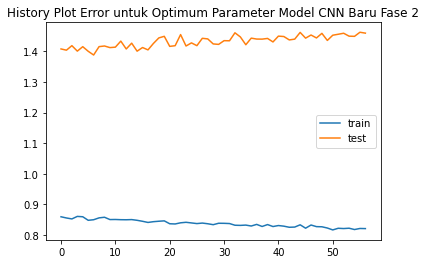

In [87]:
## Plot Training History
plt.plot(new_cnn_model_history_phase_2.history['loss'], label='train')
plt.plot(new_cnn_model_history_phase_2.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model CNN Baru Fase 2')
plt.legend()
plt.show()

##### Laporan Hasil

Berdasarkan hasil train yang terakhir, melakukan _unfreeze_ pada layer paling depat tidak memberikan hasil metrik yang _significant_ dan cenderung sama dengan hasil saat semua layer kecuali _output layer_ di-_freeze_. Hal ini menunjukkan bahwa pembobotan _node_ sudah konvergen bahkan pada saat pertama kali _model_ ini di-_load_ dari _pre-trained_ model yang sudah dijalankan sebelumnya.

#### 10.
Tuliskan analisis anda terkait implementasi menggunakan **Transfer Learning**.